In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle

In [2]:
cuts = {
    "minimum_log_stellar_mass": 9.5,
    "minimum_log_halo_mass": 10.5,
    "minimum_n_star_particles": 50
}

In [3]:
subhalos_il = pickle.load(open('data/pickle/subhalos_il.pickle', 'rb'))
halos_il = pickle.load(open('data/pickle/halos_il.pickle', 'rb'))

lengths = pickle.load(open('data/pickle/lengths.pickle', 'rb'))
offsets = pickle.load(open('data/pickle/offsets.pickle', 'rb'))

In [4]:
def flatten_nested_columns(data):
    new_data = {}
    for key, value in data.items():
        if isinstance(value, np.ndarray) and len(value.shape) == 2:
            # Handle 2D numpy arrays
            for i in range(value.shape[1]):
                new_data[f"{key}_{i}"] = value[:, i]
        elif isinstance(value, list) and isinstance(value[0], (list, np.ndarray)):
            # Handle nested lists
            nested_array = np.array(value)
            if len(nested_array.shape) == 2:
                for i in range(nested_array.shape[1]):
                    new_data[f"{key}_{i}"] = nested_array[:, i]
            else:
                raise ValueError(f"Unexpected shape for column '{key}': {nested_array.shape}")
        else:
            new_data[key] = value
    return new_data

In [5]:
halos_il = flatten_nested_columns(halos_il)
subhalos_il = flatten_nested_columns(subhalos_il)

In [6]:
halos_df = pd.DataFrame(halos_il)
subhalos_df = pd.DataFrame(subhalos_il)

In [7]:
# drop -1 from GroupFirstSub
halos_df = halos_df[halos_df['GroupFirstSub'] != -1]

In [8]:
# merge the halos_df index with the subhalos_df SubhaloGrNr
merged = pd.merge(halos_df, subhalos_df, left_index=True, right_on='SubhaloGrNr')
# make an is_central column where 3D distance is 0
merged['is_central'] = (merged['SubhaloPos_0'] == merged['GroupPos_0']) & (merged['SubhaloPos_1'] == merged['GroupPos_1']) & (merged['SubhaloPos_2'] == merged['GroupPos_2'])

In [9]:
h = 0.6774

# new columns for merged
merged_copy = merged.copy()
# remove all columns from copy
merged_copy.drop(merged_copy.columns, axis=1, inplace=True)

merged_copy['Group_M_Crit200_log'] = np.log10(merged['Group_M_Crit200'] / h) + 10
merged_copy['halo_x'] = merged['GroupPos_0'] / (h*1e3)
merged_copy['halo_y'] = merged['GroupPos_1'] / (h*1e3)
merged_copy['halo_z'] = merged['GroupPos_2'] / (h*1e3)
merged_copy['halo_vx'] = merged['GroupVel_0']
merged_copy['halo_vy'] = merged['GroupVel_1']
merged_copy['halo_vz'] = merged['GroupVel_2']
merged_copy['halo_r200'] = merged['Group_R_Crit200'] / (h*1e3)

merged_copy['subhalo_x'] = merged['SubhaloPos_0'] / (h*1e3)
merged_copy['subhalo_y'] = merged['SubhaloPos_1'] / (h*1e3)
merged_copy['subhalo_z'] = merged['SubhaloPos_2'] / (h*1e3)
merged_copy['subhalo_vx'] = merged['SubhaloVel_0']
merged_copy['subhalo_vy'] = merged['SubhaloVel_1']
merged_copy['subhalo_vz'] = merged['SubhaloVel_2']
merged_copy['subhalo_vmax'] = merged['SubhaloVmax']

merged_copy['subhalo_photo_U'] = merged['SubhaloStellarPhotometrics_0']
merged_copy['subhalo_photo_B'] = merged['SubhaloStellarPhotometrics_1']
merged_copy['subhalo_photo_V'] = merged['SubhaloStellarPhotometrics_2']
merged_copy['subhalo_photo_K'] = merged['SubhaloStellarPhotometrics_3']
merged_copy['subhalo_photo_g'] = merged['SubhaloStellarPhotometrics_4']
merged_copy['subhalo_photo_r'] = merged['SubhaloStellarPhotometrics_5']
merged_copy['subhalo_photo_i'] = merged['SubhaloStellarPhotometrics_6']
merged_copy['subhalo_photo_z'] = merged['SubhaloStellarPhotometrics_7']

merged_copy['subhalo_loggasmass'] = np.log10(merged['SubhaloMassType_0'] / h) + 10
merged_copy['subhalo_loghalomass'] = np.log10(merged['SubhaloMassType_1'] / h) + 10
merged_copy['subhalo_loghalomass_low'] = np.log10(merged['SubhaloMassType_2'] / h) + 10
merged_copy['subhalo_logtracers'] = np.log10(merged['SubhaloMassType_3'] / h) + 10
merged_copy['subhalo_logstellarmass'] = np.log10(merged['SubhaloMassType_4'] / h) + 10
merged_copy['subhalo_logbhmass'] = np.log10(merged['SubhaloMassType_5'] / h) + 10

merged_copy['subhalo_n_stellar_particles'] = merged['SubhaloLenType_4']
merged_copy['subhalo_stellarhalfmassradius'] = merged['SubhaloHalfmassRadType_4'] / (h*1e3)

merged_copy['subhalo_flag'] = merged['SubhaloFlag']
merged_copy['GroupOffsetType_0'] = merged['GroupOffsetType_0']
merged_copy['subhalo_cluster_id'] = merged['SubhaloOrigHaloID']
merged_copy['is_central'] = merged['is_central']

merged_copy = merged_copy[merged_copy['subhalo_flag'] != 0]
merged_copy.drop('subhalo_flag', axis=1, inplace=True)

merged_copy = merged_copy[merged_copy['subhalo_n_stellar_particles'] > cuts['minimum_n_star_particles']]
merged_copy = merged_copy[merged_copy['subhalo_logstellarmass'] > cuts['minimum_log_stellar_mass']]
merged_copy = merged_copy[merged_copy['subhalo_loghalomass'] > cuts['minimum_log_halo_mass']]

/opt/homebrew/Caskroom/miniforge/base/envs/gnn/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/gnn/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/gnn/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/gnn/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/gnn/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1

In [10]:
merged_copy

Group_M_Crit200_log      halo_x      halo_y      halo_z     halo_vx  \
0                   15.287194  258.772461  391.547852  666.322998 -200.378784   
1                   15.287194  258.772461  391.547852  666.322998 -200.378784   
2                   15.287194  258.772461  391.547852  666.322998 -200.378784   
3                   15.287194  258.772461  391.547852  666.322998 -200.378784   
4                   15.287194  258.772461  391.547852  666.322998 -200.378784   
...                       ...         ...         ...         ...         ...   
10373675            11.930678  638.444092  921.593933  965.328247  221.153229   
10373687            11.420603  632.799744  938.113647  963.616089  292.897064   
10373720            12.359804  628.628357  940.227417  967.139099    4.272698   
10373721            11.855486  628.593018  939.011414  967.780090  -39.170414   
10373745            11.510790  632.186768  937.094299  964.077942 -194.368301   

             halo_vy     halo_vz  halo_r200   subhalo_x   subhalo_y  ...  \
0        -212.093628  403.339722   2.628561  258.772461  391.547852  ...   
1        -212.093628  403.339722   2.628561  258.205536  386.216339  ...   
2        -212.093628  403.339722   2.628561  255.516602  384.476105  ...   
3        -212.093628  403.339722   2.628561  255.713455  392.771423  ...   
4        -212.093628  403.339722   2.628561  254.578918  381.524719  ...   
...              ...         ...        ...         ...         ...  ...   
10373675   -7.408397  -82.212891   0.199930  638.444092  921.593933  ...   
10373687 -277.065857  322.917694   0.135163  632.799744  938.113647  ...   
10373720  -40.812992 -148.835571   0.277923  628.628357  940.227417  ...   
10373721   59.330128 -314.049133   0.188728  628.593018  939.011414  ...   
10373745  -10.614328  182.689224   0.144850  632.186768  937.094299  ...   

          subhalo_loghalomass  subhalo_loghalomass_low  subhalo_logtracers  \
0                   15.340292                     -inf                -inf   
1                   14.898800                     -inf                -inf   
2                   14.123346                     -inf                -inf   
3                   14.015039                     -inf                -inf   
4                   13.576605                     -inf                -inf   
...                       ...                      ...                 ...   
10373675            10.981227                11.773351                -inf   
10373687            10.896254                11.193567                -inf   
10373720            10.674629                11.982442                -inf   
10373721            10.778322                11.695311                -inf   
10373745            10.555443                11.383899                -inf   

          subhalo_logstellarmass  subhalo_logbhmass  \
0                      13.069289          10.919228   
1                      12.777189          10.712004   
2                      12.085868           9.858829   
3                      12.134773           9.867895   
4                      11.732138           9.093664   
...                          ...                ...   
10373675                9.699314           8.019061   
10373687                9.684502           8.020268   
10373720               10.686878           9.125822   
10373721               10.052341           8.590036   
10373745                9.842944           7.959062   

          subhalo_n_stellar_particles  subhalo_stellarhalfmassradius  \
0                             1460404                       0.110385   
1                              750064                       0.103087   
2                              152998                       0.037264   
3                              171525                       0.022964   
4                               68092                       0.004993   
...                               ...                            ...   
10373675              

/var/folders/1g/jdg8wj2j06g8cm00gnn6zvzc0000gn/T/ipykernel_82935/1502651075.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subhalos_cut.loc[:, 'distance_from_center'] = distances
/var/folders/1g/jdg8wj2j06g8cm00gnn6zvzc0000gn/T/ipykernel_82935/1502651075.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subhalos_cut.loc[:, 'distance_from_center'] = distances
/var/folders/1g/jdg8wj2j06g8cm00gnn6zvzc0000gn/T/ipykernel_82935/1502651075.py:25: SettingWithCopyWarning: 
A value is trying to be set on a c

Text(0, 0.5, 'Stellar Mass')

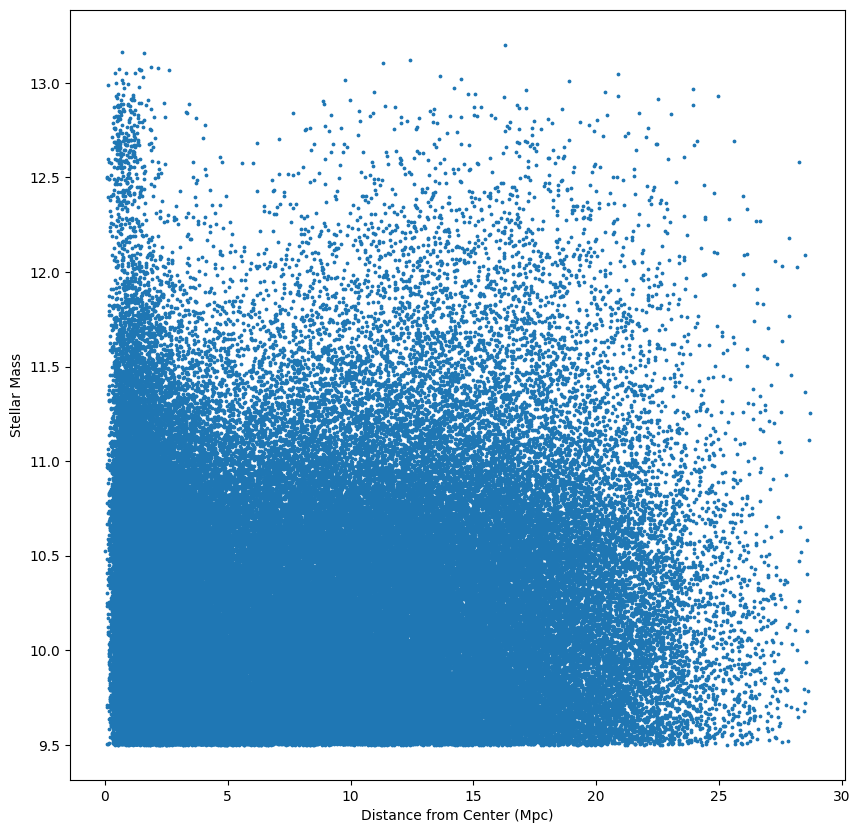

In [11]:
subhalos_new = None

# get distances from the center of the cluster for each of the galaxy by cluster
cluster_ids = merged_copy['subhalo_cluster_id'].unique()

for cluster_id in cluster_ids:
    # get the subhalos in the cluster
    subhalos_cut = merged_copy[merged_copy['subhalo_cluster_id'] == cluster_id]

    # get the center of the cluster by getting the most massive halo
    # center = subhalos_cut['subhalo_loghalomass'].idxmax()
    points = subhalos_cut[['subhalo_x', 'subhalo_y', 'subhalo_z']].values
    centeroid = np.mean(points, axis=0)

    distances = np.sqrt((subhalos_cut['subhalo_x'] - centeroid[0])**2 +
                        (subhalos_cut['subhalo_y'] - centeroid[1])**2 +
                        (subhalos_cut['subhalo_z'] - centeroid[2])**2)

    # get the distance of each subhalo from the center
    # distances = np.sqrt((subhalos_cut['subhalo_x'] - subhalos_cut['subhalo_x'][center])**2 +
    #                     (subhalos_cut['subhalo_y'] - subhalos_cut['subhalo_y'][center])**2 +
    #                     (subhalos_cut['subhalo_z'] - subhalos_cut['subhalo_z'][center])**2)
    
    # add the distances to the dataframe
    subhalos_cut.loc[:, 'distance_from_center'] = distances

    # only append the halos that are 10x more than R200
    # subhalos_cut = subhalos_cut[subhalos_cut['distance_from_center'] < 10*subhalos_cut['halo_r200'][center]]
    subhalos_cut = subhalos_cut[subhalos_cut['distance_from_center'] < 10*subhalos_cut['halo_r200'].max()]

    if subhalos_new is None:
        subhalos_new = subhalos_cut
    else:
        subhalos_new = pd.concat([subhalos_new, subhalos_cut])
    # break

# plot the distance from the center vs. stellar mass
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(subhalos_new['distance_from_center'], subhalos_new['subhalo_logstellarmass'], s=3)
ax.set_xlabel('Distance from Center (Mpc)')
ax.set_ylabel('Stellar Mass')


In [12]:
subhalos_new

Group_M_Crit200_log      halo_x      halo_y      halo_z     halo_vx  \
0                   15.287194  258.772461  391.547852  666.322998 -200.378784   
1                   15.287194  258.772461  391.547852  666.322998 -200.378784   
2                   15.287194  258.772461  391.547852  666.322998 -200.378784   
3                   15.287194  258.772461  391.547852  666.322998 -200.378784   
4                   15.287194  258.772461  391.547852  666.322998 -200.378784   
...                       ...         ...         ...         ...         ...   
10373641            11.737535  637.316528  928.757141  954.562561 -368.035095   
10373652            11.806111  631.579773  929.512451  956.161560 -139.481247   
10373675            11.930678  638.444092  921.593933  965.328247  221.153229   
10373687            11.420603  632.799744  938.113647  963.616089  292.897064   
10373745            11.510790  632.186768  937.094299  964.077942 -194.368301   

             halo_vy     halo_vz  halo_r200   subhalo_x   subhalo_y  ...  \
0        -212.093628  403.339722   2.628561  258.772461  391.547852  ...   
1        -212.093628  403.339722   2.628561  258.205536  386.216339  ...   
2        -212.093628  403.339722   2.628561  255.516602  384.476105  ...   
3        -212.093628  403.339722   2.628561  255.713455  392.771423  ...   
4        -212.093628  403.339722   2.628561  254.578918  381.524719  ...   
...              ...         ...        ...         ...         ...  ...   
10373641   24.085102  251.935532   0.172393  637.316528  928.757141  ...   
10373652 -439.272827  104.368401   0.181699  631.579773  929.512451  ...   
10373675   -7.408397  -82.212891   0.199930  638.444092  921.593933  ...   
10373687 -277.065857  322.917694   0.135163  632.799744  938.113647  ...   
10373745  -10.614328  182.689224   0.144850  632.186768  937.094299  ...   

          subhalo_loghalomass_low  subhalo_logtracers  subhalo_logstellarmass  \
0                            -inf                -inf               13.069289   
1                            -inf                -inf               12.777189   
2                            -inf                -inf               12.085868   
3                            -inf                -inf               12.134773   
4                            -inf                -inf               11.732138   
...                           ...                 ...                     ...   
10373641                11.555295                -inf                9.577237   
10373652                11.628934                -inf                9.548032   
10373675                11.773351                -inf                9.699314   
10373687                11.193567                -inf                9.684502   
10373745                11.383899                -inf                9.842944   

          subhalo_logbhmass  subhalo_n_stellar_particles  \
0                 10.919228                      1460404   
1                 10.712004                       750064   
2                  9.858829                       152998   
3                  9.867895                       171525   
4                  9.093664                        68092   
...                     ...                          ...   
10373641           7.275354                          135   
10373652           7.233318                           85   
10373675           8.019061                           54   
10373687           8.020268                          550   
10373745           7.959062                           80   

          subhalo_stellarhalfmassradius  GroupOffsetType_0  \
0                              0.110385                  0   
1                              0.103087                  0   
2                              0.037264                  0   
3                              0.022964                  0   
4                              0.004993                  0   
...                                 ...                ...

(<Figure size 1800x1800 with 2 Axes>,
 <Axes: xlabel='$\\log_{10}(M_{\\rm halo} / M_{\\odot})$', ylabel='$\\log_{10}(M_{\\rm star} / M_{\\odot})$'>)

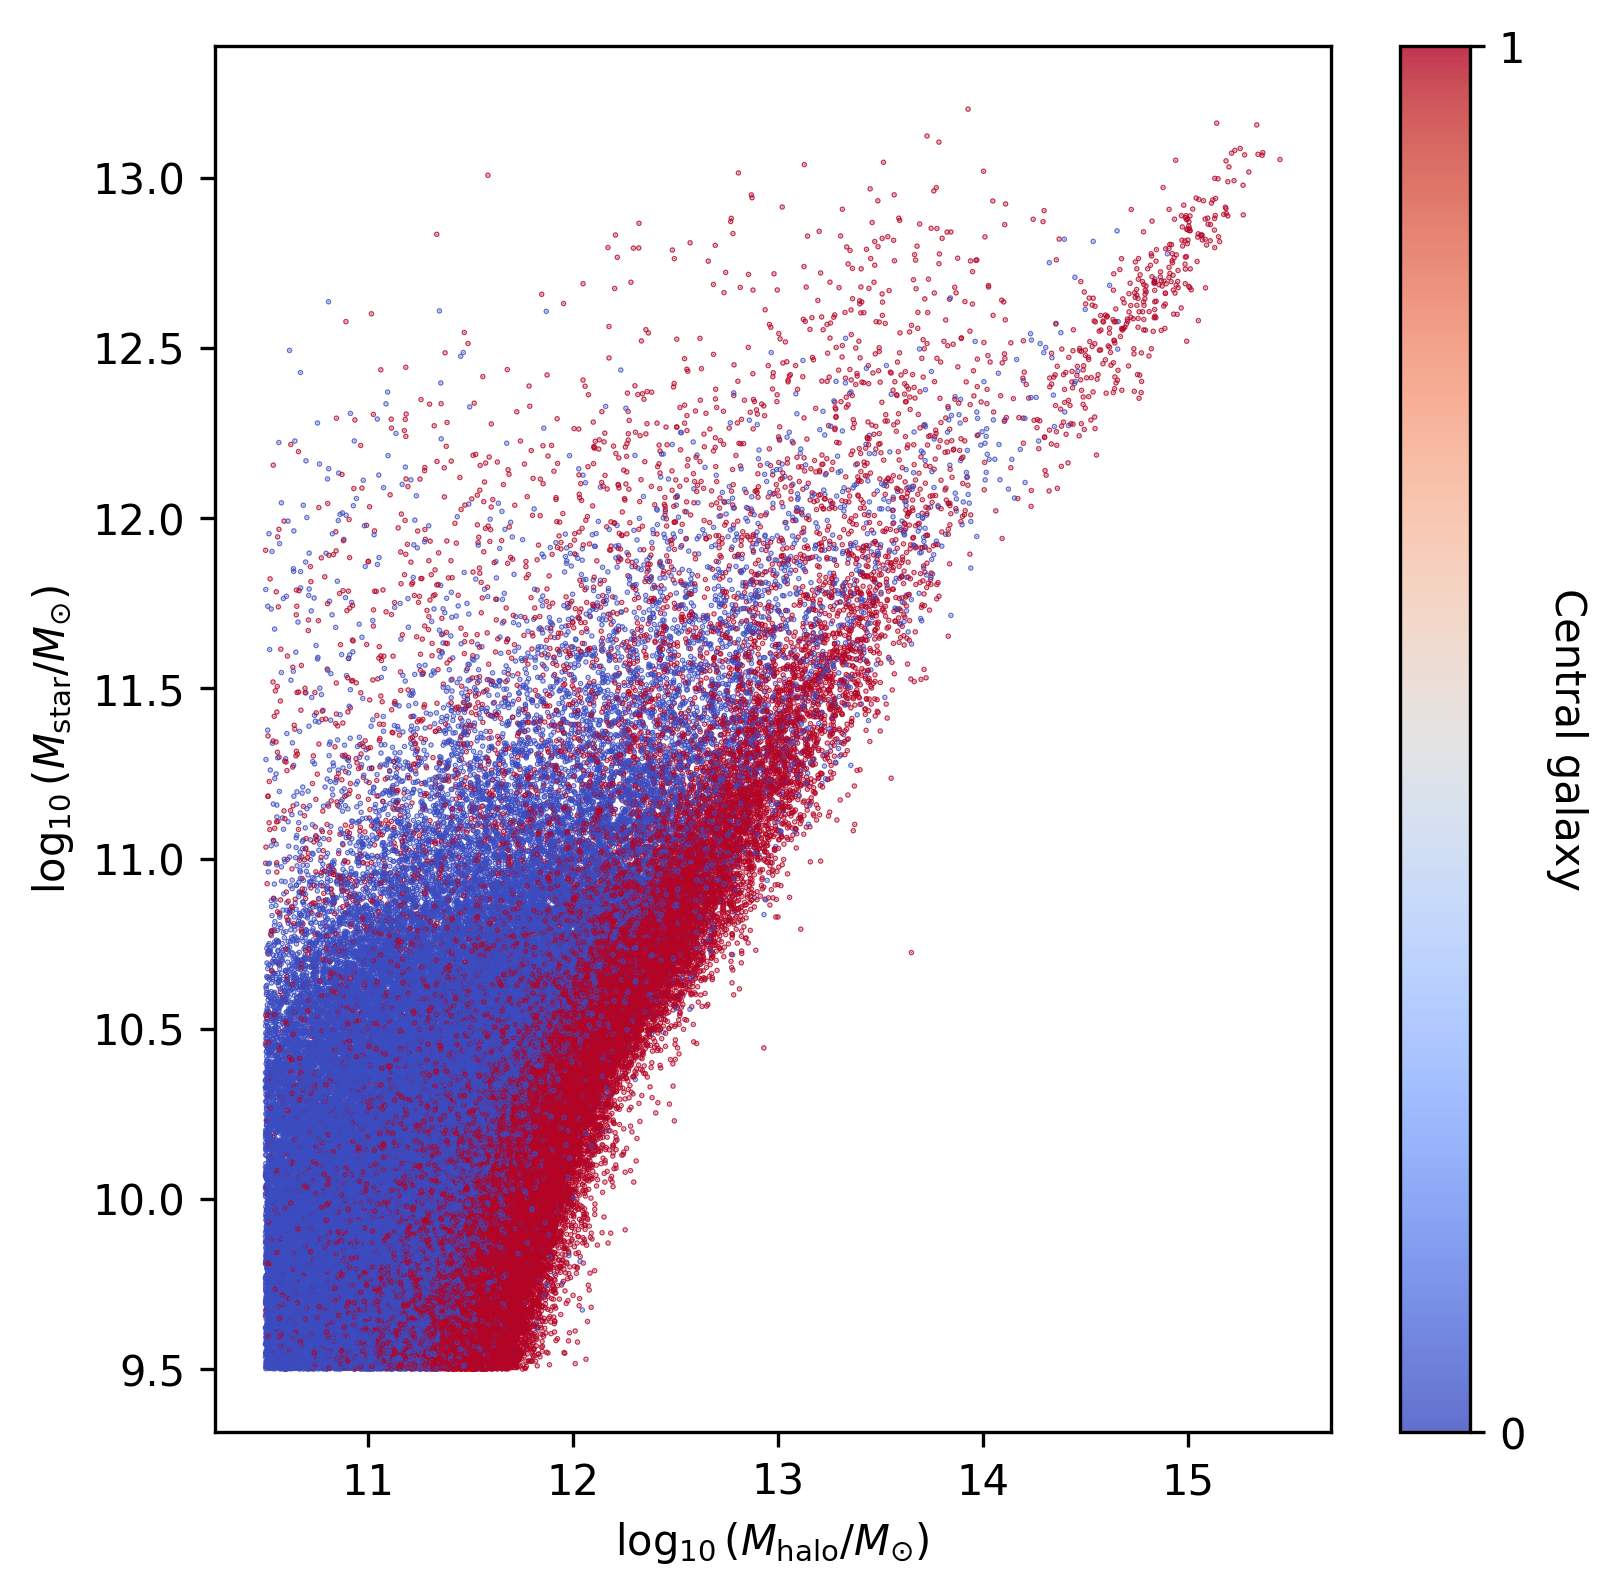

In [15]:
from plotting import is_central_plot

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)

is_central_plot(fig, ax, subhalos_new['subhalo_loghalomass'], subhalos_new['subhalo_logstellarmass'], subhalos_new['is_central'])

0.33198187


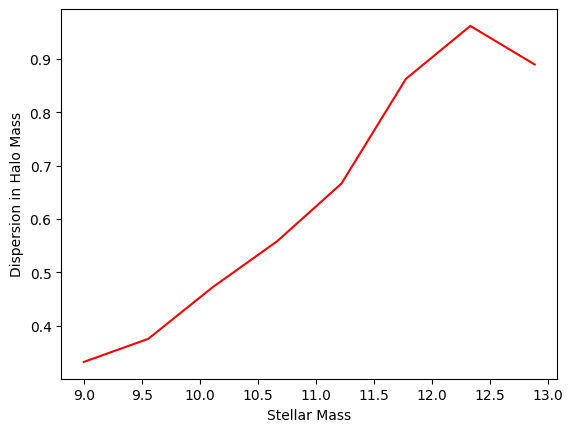

In [14]:
# get dispersion in halo mass for each stellar mass bin
stellar_mass_bins = np.linspace(9, 14, 10)

halo_mass_dispersion = []
for i in range(len(stellar_mass_bins) - 1):
    mask = (subhalos_new['subhalo_logstellarmass'] > stellar_mass_bins[i]) & (subhalos_new['subhalo_logstellarmass'] < stellar_mass_bins[i+1])
    halo_mass_dispersion.append(np.std(subhalos_new['subhalo_loghalomass'][mask]))

plt.plot(stellar_mass_bins[:-1], halo_mass_dispersion, color='red')
plt.xlabel('Stellar Mass')
plt.ylabel('Dispersion in Halo Mass')

# min dex of the halo mass dispersion
print(min(halo_mass_dispersion))
np.save('data/halo_mass_dispersion.npy', halo_mass_dispersion)

In [15]:
# check which rows aren't there in subhalos_new but are there in merged_copy
missing_rows = merged_copy[~merged_copy.index.isin(subhalos_new.index)]
missing_rows

Group_M_Crit200_log      halo_x      halo_y      halo_z     halo_vx  \
26830               14.150705  270.947998  365.592468  669.849854 -873.159241   
26831               14.150705  270.947998  365.592468  669.849854 -873.159241   
26832               14.150705  270.947998  365.592468  669.849854 -873.159241   
26833               14.150705  270.947998  365.592468  669.849854 -873.159241   
26834               14.150705  270.947998  365.592468  669.849854 -873.159241   
...                       ...         ...         ...         ...         ...   
10373553            13.719807  639.346069  916.531494  962.458740 -160.249893   
10373603            13.223915  650.707336  930.568970  952.341797 -302.965912   
10373610            11.930107  632.269287  927.181091  952.732483 -433.086243   
10373720            12.359804  628.628357  940.227417  967.139099    4.272698   
10373721            11.855486  628.593018  939.011414  967.780090  -39.170414   

             halo_vy     halo_vz  halo_r200   subhalo_x   subhalo_y  ...  \
26830    -130.074600  231.702164   1.098706  270.947998  365.592468  ...   
26831    -130.074600  231.702164   1.098706  270.759705  365.847412  ...   
26832    -130.074600  231.702164   1.098706  271.978760  365.986145  ...   
26833    -130.074600  231.702164   1.098706  271.044922  365.948151  ...   
26834    -130.074600  231.702164   1.098706  270.788513  365.922150  ...   
...              ...         ...        ...         ...         ...  ...   
10373553   91.397072   82.733368   0.789329  639.346069  916.531494  ...   
10373603 -171.938461  208.129929   0.539474  650.707336  930.568970  ...   
10373610 -284.146515 -349.553528   0.199850  632.269287  927.181091  ...   
10373720  -40.812992 -148.835571   0.277923  628.628357  940.227417  ...   
10373721   59.330128 -314.049133   0.188728  628.593018  939.011414  ...   

          subhalo_loghalomass  subhalo_loghalomass_low  subhalo_logtracers  \
26830               13.949464                13.400056                -inf   
26831               12.625414                     -inf                -inf   
26832               12.254368                     -inf                -inf   
26833               11.702044                     -inf                -inf   
26834               11.716633                     -inf                -inf   
...                       ...                      ...                 ...   
10373553            10.569944                12.637221                -inf   
10373603            10.663274                12.585384                -inf   
10373610            11.202467                11.667054                -inf   
10373720            10.674629                11.982442                -inf   
10373721            10.778322                11.695311                -inf   

          subhalo_logstellarmass  subhalo_logbhmass  \
26830                  12.172047           9.853212   
26831                  11.442970           9.239560   
26832                  10.964569           8.475220   
26833                  10.542461           8.423635   
26834                  10.401198           8.014622   
...                          ...                ...   
10373553               11.848384               -inf   
10373603               11.635024           9.100854   
10373610                9.828407           7.333523   
10373720               10.686878           9.125822   
10373721               10.052341           8.590036   

          subhalo_n_stellar_particles  subhalo_stellarhalfmassradius  \
26830                          175475                       0.024018   
26831                           35218                       0.012251   
26832                           11710                       0.008998   
26833                            4377                       0.004948   
26834                            3119                       0.006178   
...                               ...                            ...   
10373553              

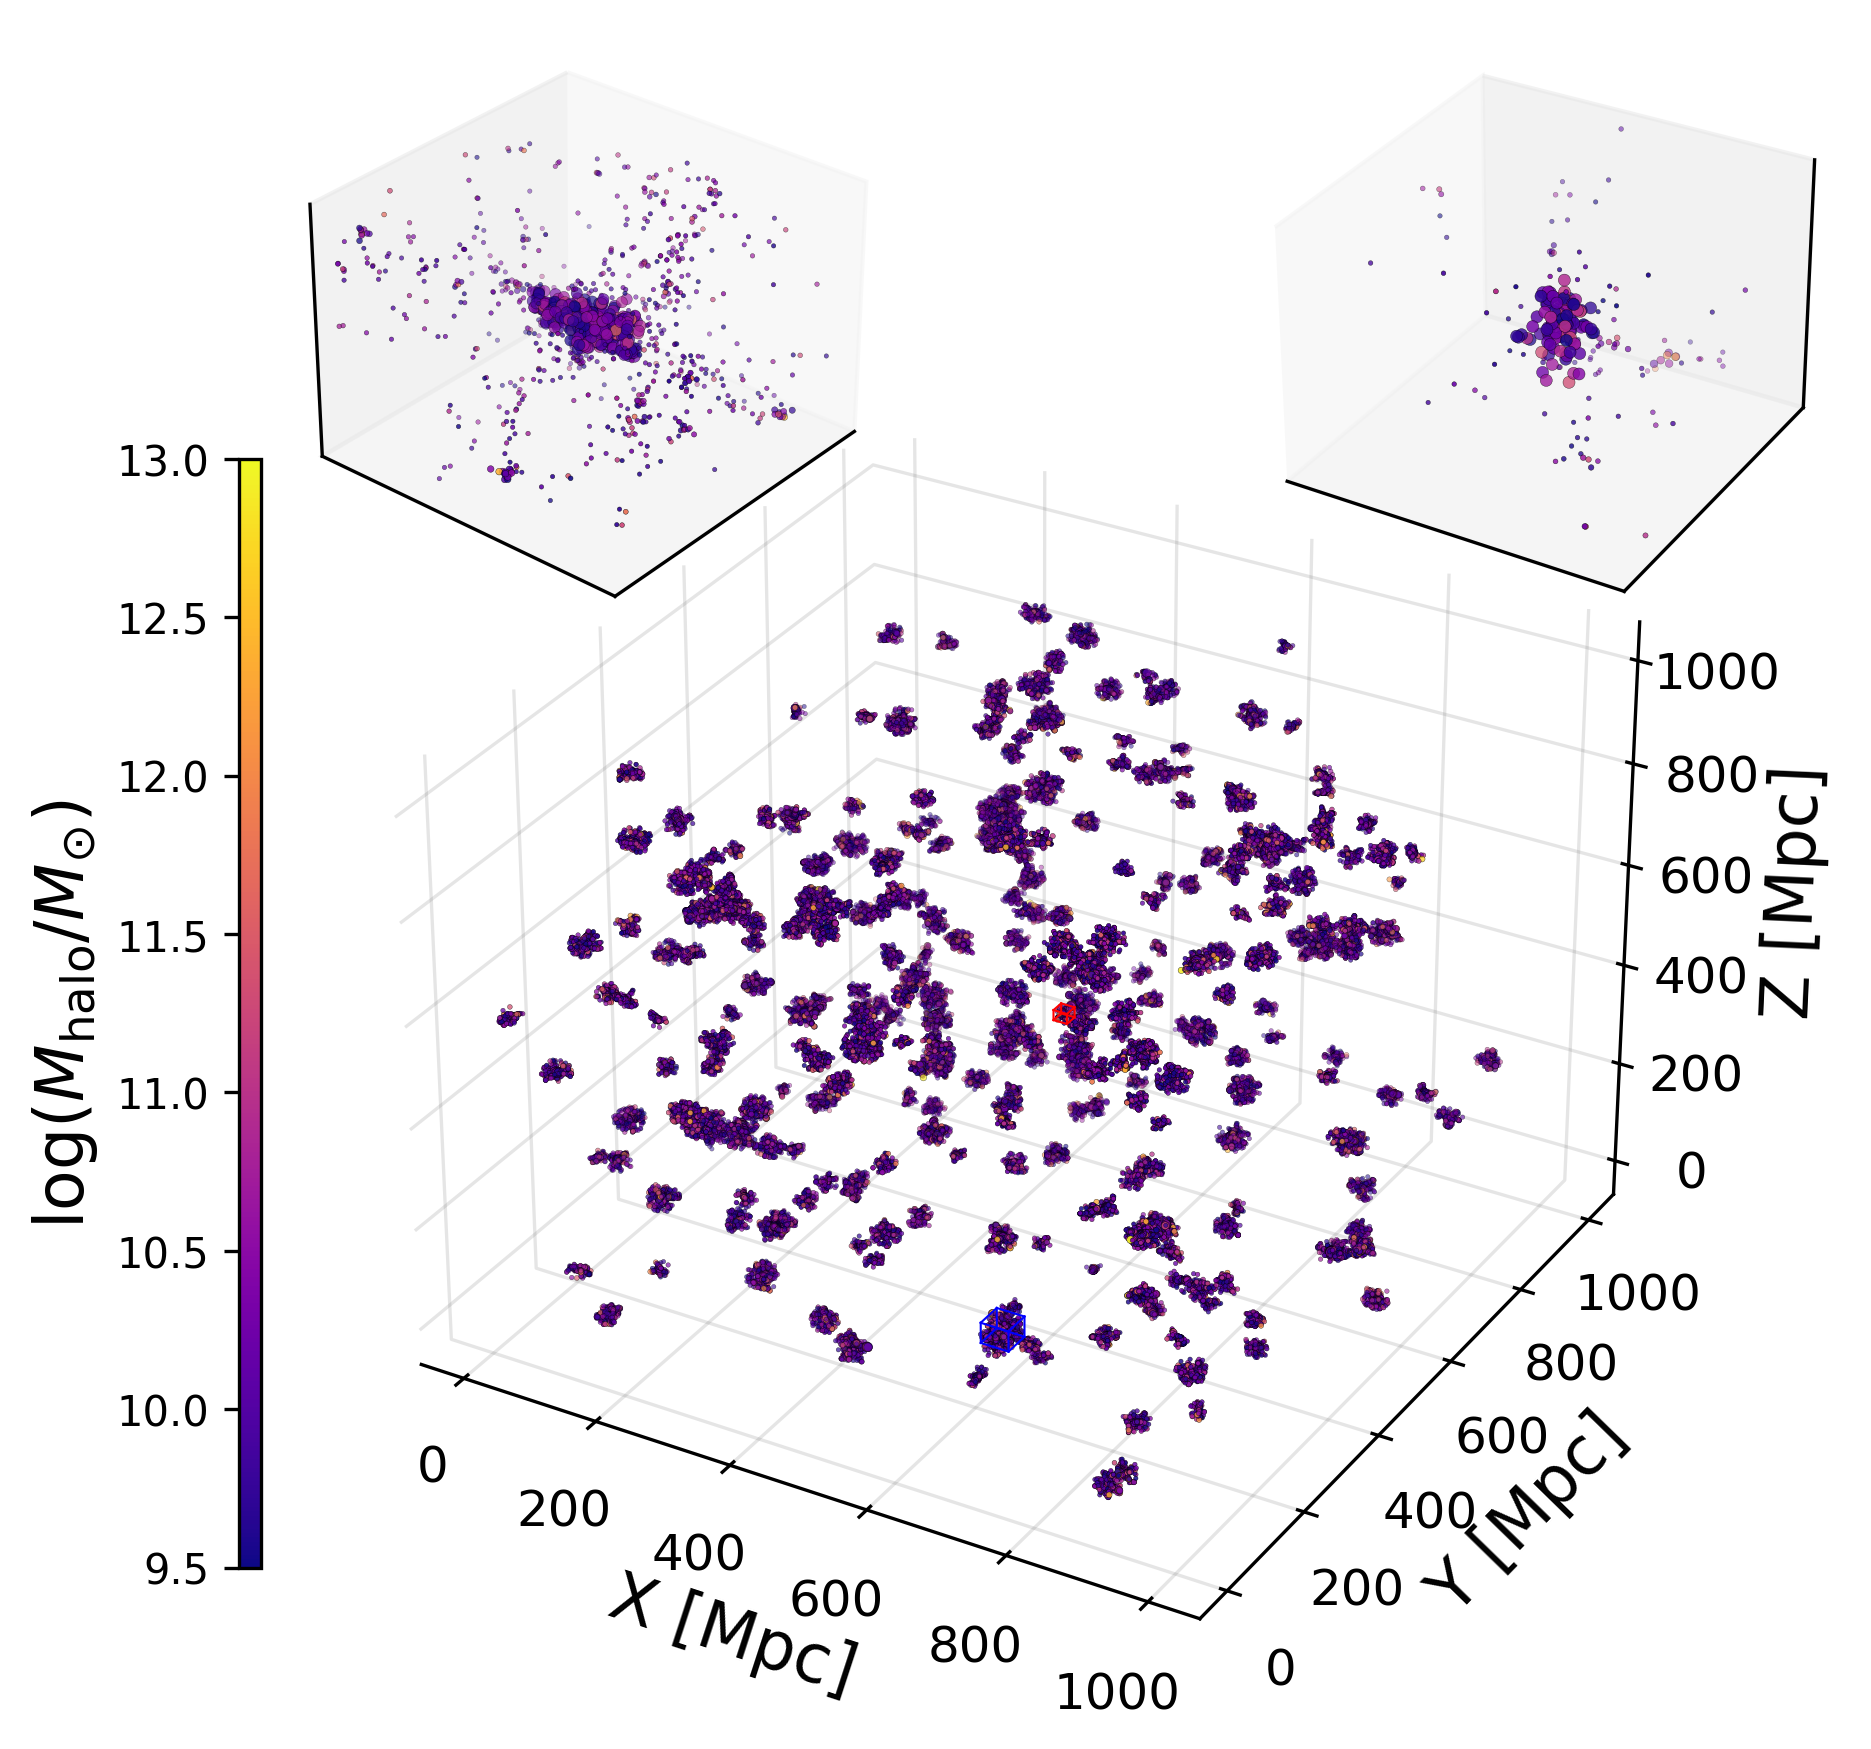

In [17]:
# scatter plot of the halo distribution in 3d
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# get the subhalos in the cluster
pos = subhalos_new[['subhalo_x', 'subhalo_y', 'subhalo_z']].values
mass = subhalos_new['subhalo_logstellarmass'].values
r200 = subhalos_new['halo_r200'].values

# plot the subhalos
sc = ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=mass, s=2**r200, cmap='plasma', vmin=9.5, vmax=13, edgecolor='k', linewidths=0.1)

# colorbar
cbar = plt.colorbar(sc, shrink=0.8, aspect=50, location='left', pad=0.03)
cbar.set_label("log($M_{\\rm halo} / M_{\\odot})$", fontsize=16)

# axis information
ax.set_xlabel('X [Mpc]', fontsize=16)
ax.set_ylabel('Y [Mpc]', fontsize=16)
ax.set_zlabel('Z [Mpc]', fontsize=16)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.yaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.zaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)

# Define the region of interest (ROI) for the zoom-in
roi_center = np.array([502, 598, 400])
# roi_center = np.array([817.406250,	920.983887,	569.646301	])
roi_size = 10
roi_mask = (
    (pos[:, 0] > roi_center[0] - roi_size) & (pos[:, 0] < roi_center[0] + roi_size) &
    (pos[:, 1] > roi_center[1] - roi_size) & (pos[:, 1] < roi_center[1] + roi_size) &
    (pos[:, 2] > roi_center[2] - roi_size) & (pos[:, 2] < roi_center[2] + roi_size)
)
pos_roi = pos[roi_mask]
mass_roi = mass[roi_mask]
r200_roi = r200[roi_mask]

# Add the zoom-in plot
zoom_ax = fig.add_axes([0.65, 0.65, 0.25, 0.45], projection='3d', facecolor='none')
zoom_sc = zoom_ax.scatter(pos_roi[:, 0], pos_roi[:, 1], pos_roi[:, 2], c=mass_roi, s=3.5**r200_roi, cmap='plasma', vmin=9.5, vmax=13, edgecolor='k', linewidths=0.1)


# Axis labels and adjustments for the zoom-in plot
zoom_ax.set_xlim(roi_center[0] - roi_size, roi_center[0] + roi_size)
zoom_ax.set_ylim(roi_center[1] - roi_size, roi_center[1] + roi_size)
zoom_ax.set_zlim(roi_center[2] - roi_size, roi_center[2] + roi_size)
zoom_ax.set_xticks([])
zoom_ax.set_yticks([])
zoom_ax.set_zticks([])

# Add a box to highlight the ROI in the main plot
ax.plot([roi_center[0] - roi_size, roi_center[0] + roi_size], [roi_center[1] - roi_size, roi_center[1] - roi_size], [roi_center[2] - roi_size, roi_center[2] - roi_size], color='r', zorder=10, linewidth=0.5)
ax.plot([roi_center[0] - roi_size, roi_center[0] + roi_size], [roi_center[1] + roi_size, roi_center[1] + roi_size], [roi_center[2] - roi_size, roi_center[2] - roi_size], color='r', zorder=10, linewidth=0.5)
ax.plot([roi_center[0] - roi_size, roi_center[0] + roi_size], [roi_center[1] - roi_size, roi_center[1] - roi_size], [roi_center[2] + roi_size, roi_center[2] + roi_size], color='r', zorder=10, linewidth=0.5)
ax.plot([roi_center[0] - roi_size, roi_center[0] + roi_size], [roi_center[1] + roi_size, roi_center[1] + roi_size], [roi_center[2] + roi_size, roi_center[2] + roi_size], color='r', zorder=10, linewidth=0.5)

ax.plot([roi_center[0] - roi_size, roi_center[0] - roi_size], [roi_center[1] - roi_size, roi_center[1] + roi_size], [roi_center[2] - roi_size, roi_center[2] - roi_size], color='r', zorder=10, linewidth=0.5)
ax.plot([roi_center[0] + roi_size, roi_center[0] + roi_size], [roi_center[1] - roi_size, roi_center[1] + roi_size], [roi_center[2] - roi_size, roi_center[2] - roi_size], color='r', zorder=10, linewidth=0.5)
ax.plot([roi_center[0] - roi_size, roi_center[0] - roi_size], [roi_center[1] - roi_size, roi_center[1] + roi_size], [roi_center[2] + roi_size, roi_center[2] + roi_size], color='r', zorder=10, linewidth=0.5)
ax.plot([roi_center[0] + roi_size, roi_center[0] + roi_size], [roi_center[1] - roi_size, roi_center[1] + roi_size], [roi_center[2] + roi_size, roi_center[2] + roi_size], color='r', zorder=10, linewidth=0.5)

ax.plot([roi_center[0] - roi_size, roi_center[0] - roi_size], [roi_center[1] - roi_size, roi_center[1] - roi_size], [roi_center[2] - roi_size, roi_center[2] + roi_size], color='r', zorder=10, linewidth=0.5)
ax.plot([roi_center[0] + roi_size, roi_center[0] + roi_size], [roi_center[1] - roi_size, roi_center[1] - roi_size], [roi_center[2] - roi_size, roi_center[2] + roi_size], color='r', zorder=10, linewidth=0.5)
ax.plot([roi_center[0] - roi_size, roi_center[0] - roi_size], [roi_center[1] + roi_size, roi_center[1] + roi_size], [roi_center[2] - roi_size, roi_center[2] + roi_size], color='r', zorder=10, linewidth=0.5)
ax.plot([roi_center[0] + roi_size, roi_center[0] + roi_size], [roi_center[1] + roi_size, roi_center[1] + roi_size], [roi_center[2] - roi_size, roi_center[2] + roi_size], color='r', zorder=10, linewidth=0.5)


# Define the region of interest (ROI) for the second zoom-in
roi_center2 = np.array([258.772461,	391.547852,	666.322998]) # ID 0
roi_center2 = np.array([669.756836,	148.352570,	155.136078])
roi_size2 = 20
roi_mask2 = (
    (pos[:, 0] > roi_center2[0] - roi_size2) & (pos[:, 0] < roi_center2[0] + roi_size2) &
    (pos[:, 1] > roi_center2[1] - roi_size2) & (pos[:, 1] < roi_center2[1] + roi_size2) &
    (pos[:, 2] > roi_center2[2] - roi_size2) & (pos[:, 2] < roi_center2[2] + roi_size2)
)
pos_roi2 = pos[roi_mask2]
mass_roi2 = mass[roi_mask2]
r200_roi2 = r200[roi_mask2]

# Add the second zoom-in plot
zoom_ax2 = fig.add_axes([0.25, 0.65, 0.25, 0.45], projection='3d', facecolor='none')
zoom_sc2 = zoom_ax2.scatter(pos_roi2[:, 0], pos_roi2[:, 1], pos_roi2[:, 2], c=mass_roi2, s=2.0**r200_roi2, cmap='plasma', vmin=9.5, vmax=13, edgecolor='k', linewidths=0.1)
zoom_ax2.view_init(elev=30, azim=40)  # Adjust orientation here

# Axis labels and adjustments for the second zoom-in plot
zoom_ax2.set_xlim(roi_center2[0] - roi_size2, roi_center2[0] + roi_size2)
zoom_ax2.set_ylim(roi_center2[1] - roi_size2, roi_center2[1] + roi_size2)
zoom_ax2.set_zlim(roi_center2[2] - roi_size2, roi_center2[2] + roi_size2)
zoom_ax2.set_xticks([])
zoom_ax2.set_yticks([])
zoom_ax2.set_zticks([])

# Add a box to highlight the ROI in the main plot for the second zoom-in
ax.plot([roi_center2[0] - roi_size2, roi_center2[0] + roi_size2], [roi_center2[1] - roi_size2, roi_center2[1] - roi_size2], [roi_center2[2] - roi_size2, roi_center2[2] - roi_size2], color='b', zorder=10, linewidth=0.5)
ax.plot([roi_center2[0] - roi_size2, roi_center2[0] + roi_size2], [roi_center2[1] + roi_size2, roi_center2[1] + roi_size2], [roi_center2[2] - roi_size2, roi_center2[2] - roi_size2], color='b', zorder=10, linewidth=0.5)
ax.plot([roi_center2[0] - roi_size2, roi_center2[0] + roi_size2], [roi_center2[1] - roi_size2, roi_center2[1] - roi_size2], [roi_center2[2] + roi_size2, roi_center2[2] + roi_size2], color='b', zorder=10, linewidth=0.5)
ax.plot([roi_center2[0] - roi_size2, roi_center2[0] + roi_size2], [roi_center2[1] + roi_size2, roi_center2[1] + roi_size2], [roi_center2[2] + roi_size2, roi_center2[2] + roi_size2], color='b', zorder=10, linewidth=0.5)

ax.plot([roi_center2[0] - roi_size2, roi_center2[0] - roi_size2], [roi_center2[1] - roi_size2, roi_center2[1] + roi_size2], [roi_center2[2] - roi_size2, roi_center2[2] - roi_size2], color='b', zorder=10, linewidth=0.5)
ax.plot([roi_center2[0] + roi_size2, roi_center2[0] + roi_size2], [roi_center2[1] - roi_size2, roi_center2[1] + roi_size2], [roi_center2[2] - roi_size2, roi_center2[2] - roi_size2], color='b', zorder=10, linewidth=0.5)
ax.plot([roi_center2[0] - roi_size2, roi_center2[0] - roi_size2], [roi_center2[1] - roi_size2, roi_center2[1] + roi_size2], [roi_center2[2] + roi_size2, roi_center2[2] + roi_size2], color='b', zorder=10, linewidth=0.5)
ax.plot([roi_center2[0] + roi_size2, roi_center2[0] + roi_size2], [roi_center2[1] - roi_size2, roi_center2[1] + roi_size2], [roi_center2[2] + roi_size2, roi_center2[2] + roi_size2], color='b', zorder=10, linewidth=0.5)

ax.plot([roi_center2[0] - roi_size2, roi_center2[0] - roi_size2], [roi_center2[1] - roi_size2, roi_center2[1] - roi_size2], [roi_center2[2] - roi_size2, roi_center2[2] + roi_size2], color='b', zorder=10, linewidth=0.5)
ax.plot([roi_center2[0] + roi_size2, roi_center2[0] + roi_size2], [roi_center2[1] - roi_size2, roi_center2[1] - roi_size2], [roi_center2[2] - roi_size2, roi_center2[2] + roi_size2], color='b', zorder=10, linewidth=0.5)
ax.plot([roi_center2[0] - roi_size2, roi_center2[0] - roi_size2], [roi_center2[1] + roi_size2, roi_center2[1] + roi_size2], [roi_center2[2] - roi_size2, roi_center2[2] + roi_size2], color='b', zorder=10, linewidth=0.5)
ax.plot([roi_center2[0] + roi_size2, roi_center2[0] + roi_size2], [roi_center2[1] + roi_size2, roi_center2[1] + roi_size2], [roi_center2[2] - roi_size2, roi_center2[2] + roi_size2], color='b', zorder=10, linewidth=0.5)

plt.savefig('halo_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# save the new subhalos
# subhalos_new.to_parquet('data/TNGCluster-subhalos_99_new.parquet')

12


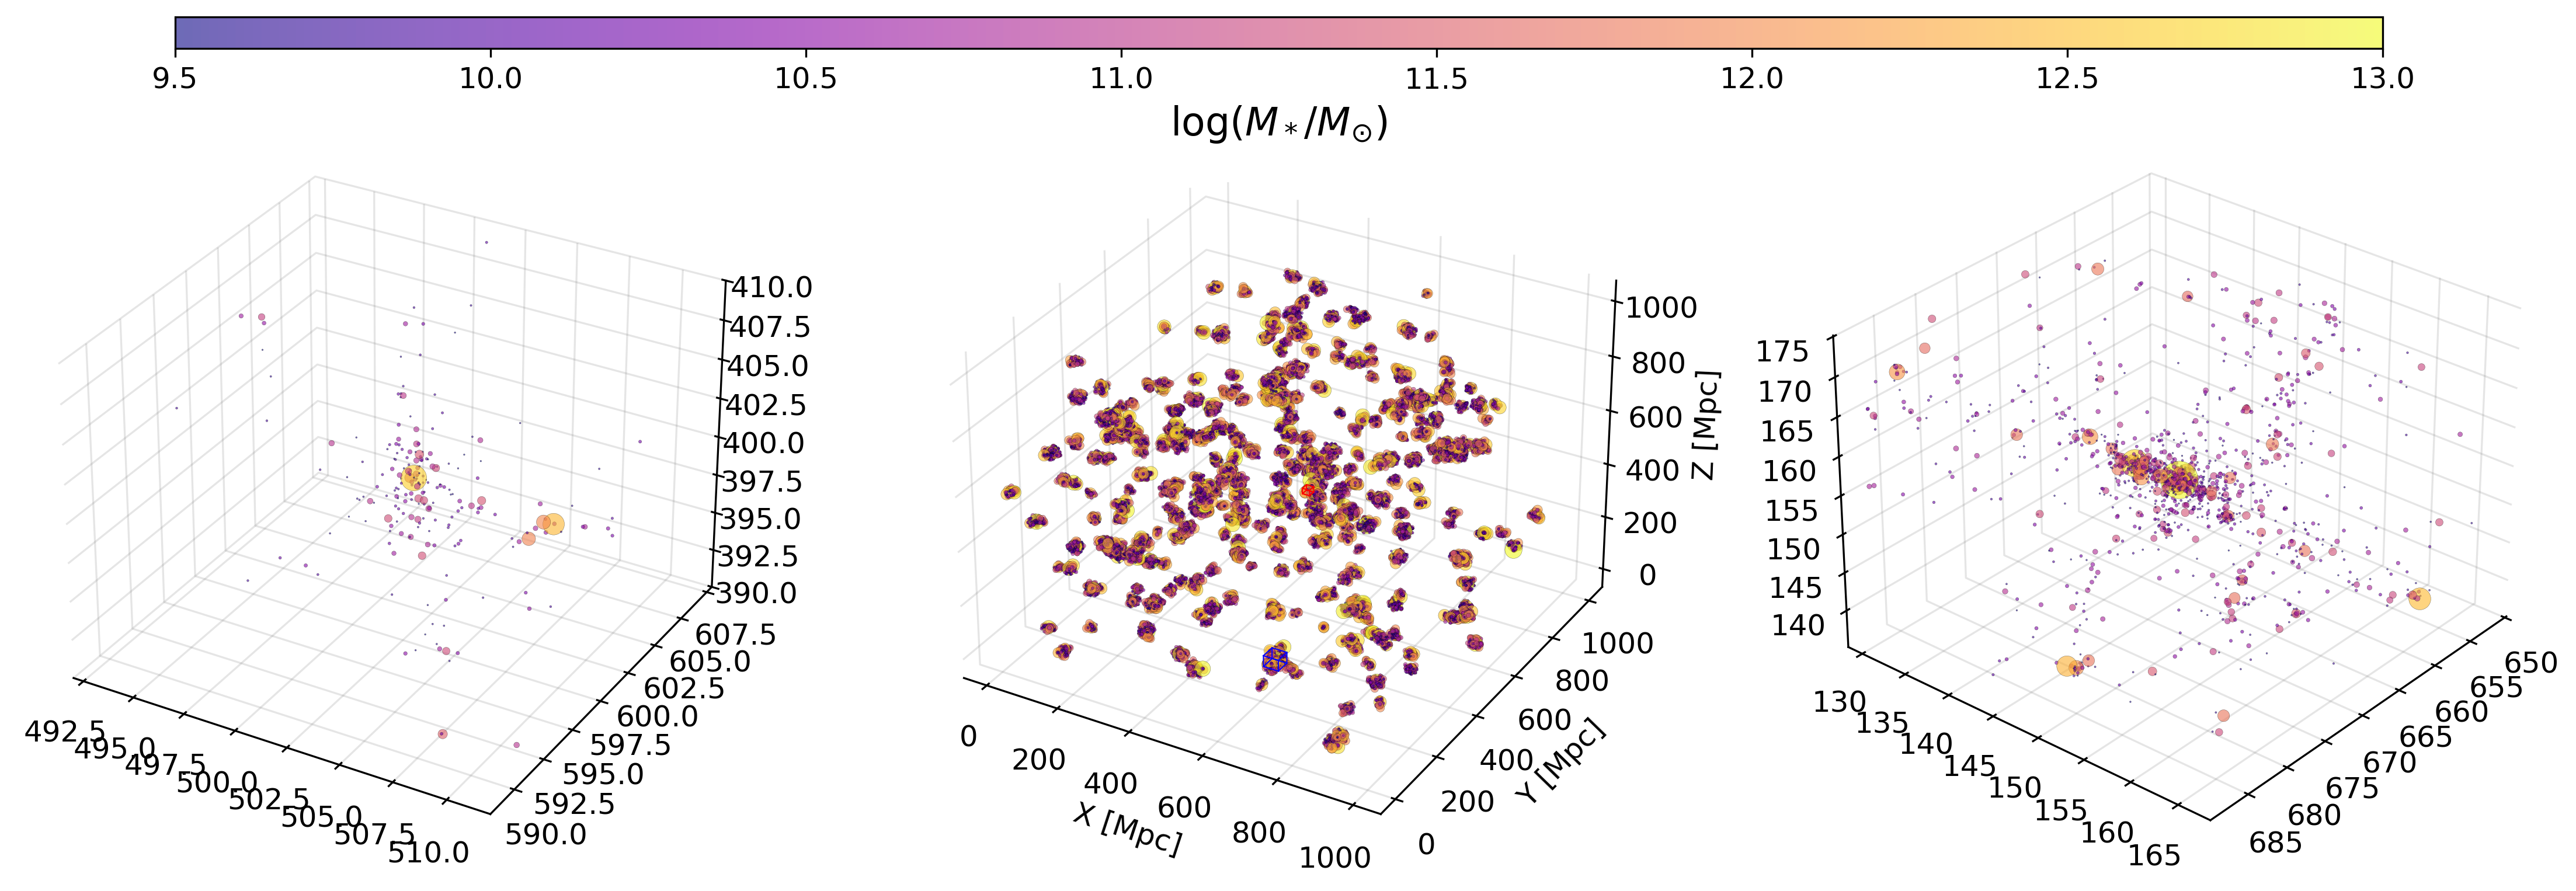

In [19]:
from plotting import visualise_graph

fig, _ = visualise_graph(pos, mass)

# save the figure
fig.savefig('cluster_graph.pdf', dpi=300, bbox_inches='tight')